<a href="https://colab.research.google.com/github/hakurennnn/cnn/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import glob
import imageio
from keras.applications import densenet
from tensorflow.keras import layers

In [3]:
#paths
main_path = 'E:\Repositories'

test_path = os.path.join(main_path,"test") #after ng main path, folder names.
train_path = os.path.join(main_path,"train")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg") #parang os.listdir yung glob, nirereturn lahat ng .jpeg
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")



In [4]:
# combine train_normal and train_pneumonia
train_list = train_normal + train_pneumonia
test_list = test_normal + test_pneumonia

df_train = pd.DataFrame({'class': ['Normal']*len(train_normal) + ['Pneumonia']*len(train_pneumonia),
                         'image': train_list})

df_test = pd.DataFrame({'class': ['Normal']*len(test_normal) + ['Pneumonia']*len(test_pneumonia),
                        'image': test_list})


In [5]:
df_train

,class,image
0,Normal,E:\Repositories\train/NORMAL\NORMAL-1003233-00...
1,Normal,E:\Repositories\train/NORMAL\NORMAL-1012843-00...
2,Normal,E:\Repositories\train/NORMAL\NORMAL-1014768-00...
3,Normal,E:\Repositories\train/NORMAL\NORMAL-1023731-00...
4,Normal,E:\Repositories\train/NORMAL\NORMAL-1029510-00...
...,...,...
5227,Pneumonia,E:\Repositories\train/PNEUMONIA\VIRUS-9934736-...
5228,Pneumonia,E:\Repositories\train/PNEUMONIA\VIRUS-9947411-...
5229,Pneumonia,E:\Repositories\train/PNEUMONIA\VIRUS-9962961-...
5230,Pneumonia,E:\Repositories\train/PNEUMONIA\VIRUS-9963654-...


In [6]:
df_test

,class,image
0,Normal,E:\Repositories\test/NORMAL\NORMAL-1049278-000...
1,Normal,E:\Repositories\test/NORMAL\NORMAL-1110860-000...
2,Normal,E:\Repositories\test/NORMAL\NORMAL-11419-0001....
3,Normal,E:\Repositories\test/NORMAL\NORMAL-115218-0001...
4,Normal,E:\Repositories\test/NORMAL\NORMAL-1160949-000...
...,...,...
619,Pneumonia,E:\Repositories\test/PNEUMONIA\VIRUS-9584831-0...
620,Pneumonia,E:\Repositories\test/PNEUMONIA\VIRUS-9671740-0...
621,Pneumonia,E:\Repositories\test/PNEUMONIA\VIRUS-9783315-0...
622,Pneumonia,E:\Repositories\test/PNEUMONIA\VIRUS-9890836-0...


# Creating the model

In [7]:
# Create validation set
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 32, stratify = df_train['class'])

In [8]:
batch = 32
img_size = 224

Normal


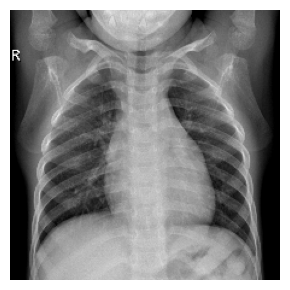

In [9]:
print('Normal')

plt.figure(figsize=(3,3))

for i in range(0, 12):
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (img_size,img_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Pneumonia


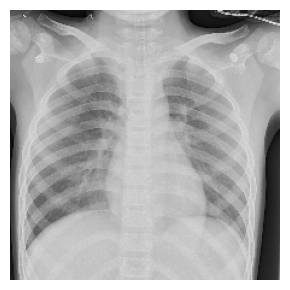

In [10]:
print('Pneumonia')

plt.figure(figsize=(3,3))

for i in range(0, 12):
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (img_size,img_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [11]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               vertical_flip = True)

val_gen = ImageDataGenerator(rescale=1/255.)

ds_train = train_gen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (img_size, img_size),
                                             batch_size = batch,
                                             class_mode = 'binary',
                                             color_mode = 'rgb'
                                             )

ds_val = val_gen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (img_size, img_size),
                                            batch_size = batch,
                                            class_mode = 'binary',
                                            color_mode = 'rgb')

ds_test = val_gen.flow_from_dataframe(df_test,
                                       x_col='image',
                                       y_col='class',
                                       target_size=(img_size, img_size),
                                       batch_size=batch,
                                       class_mode='binary',
                                       color_mode='rgb')


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)

In [13]:
def predict_image(model, img_path, preprocess_input_fn, decode_predictions_fn, target_size=(img_size,img_size)):

    img = tensorflow.keras.utils.load_img(img_path, target_size=target_size)
    x = tensorflow.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    
    preds = model.predict(x)
    predictions_df = pd.DataFrame(decode_predictions_fn(preds, top=10)[0])
    predictions_df.columns = ["Predicted Class", "Name", "Probability"]
    return predictions_df

In [14]:
pre_model = densenet.DenseNet121(weights=None,
    classifier_activation="softmax",)

In [15]:
model = Sequential()

# Add DenseNet121 base
model.add(pre_model)

# Add new output layer with 2 units and "softmax" activation
model.add(Dense(1, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 8,063,505
Trainable params: 7,979,857
Non-trainable params: 83,648
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [20]:
results = model.fit(ds_train,
                        batch_size=batch,
                        epochs=50,
                        validation_data=ds_val,
                        steps_per_epoch=(len(train_df)/batch),
                        callbacks=[early_stopping], 
                        verbose=1)


Epoch 1/50


KeyboardInterrupt: 